## 3.一般線形化モデル(GLM)

In [1]:
import numpy as np
from scipy.stats import poisson
import matplotlib.pyplot as plt
import polars as pl

In [2]:
df = pl.read_csv('./data/chapter3/data3a.csv')
f2id = {'C': 0, 'T': 1}

# メモリの節約(今回はデータ数が少ないのでする必要はないけど、good practiceとして)
df = df.with_columns(
  [
    pl.col('y').cast(pl.datatypes.Int16),
    pl.col('x').cast(pl.datatypes.Float32),
    pl.col('f').apply(lambda x: f2id[x]).alias('f2').cast(pl.datatypes.Int8)
  ]
)
df.head()

y,x,f,f2
i16,f32,str,i8
6,8.31,"""C""",0
6,9.44,"""C""",0
6,9.5,"""C""",0
12,9.07,"""C""",0
10,10.16,"""C""",0


## EDA: Explanatory Data Analysis

In [3]:
# pandasのinfo()のようにまとめてサマリしてくれるメソッドあるかも
df.mean()

y,x,f,f2
f64,f32,str,f64
7.83,10.0891,null,0.5


In [4]:
df.var()

y,x,f,f2
f64,f32,str,f64
6.89,1.016162,null,0.252525


In [5]:
df.groupby('f').agg(pl.count())

f,count
str,u32
"""T""",50
"""C""",50


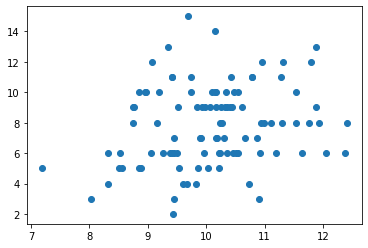

In [6]:
# 植物の大きさ(x)と種子量の関係を図示する
x = df[['x']].to_numpy().flatten().tolist()
y = df[['y']].to_numpy().flatten().tolist()
plt.scatter(x, y)

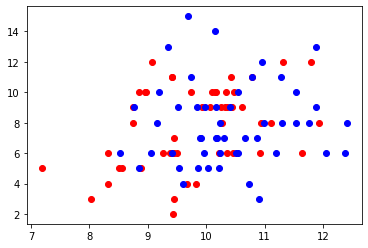

In [7]:
# 肥料あり(T), 肥料なし(C)にわけて図示する
control = df.filter(pl.col('f') == 'C')
control_x = control[['x']].to_numpy().tolist()
control_y = control[['y']].to_numpy().tolist()

treatment = df.filter(pl.col('f') == 'T')
treatment_x = treatment[['x']].to_numpy().tolist()
treatment_y = treatment[['y']].to_numpy().tolist()

plt.scatter(control_x, control_y, color='red')
plt.scatter(treatment_x, treatment_y, color='blue')

## ポアソン回帰の統計モデル

In [8]:
import statsmodels.api as sm
import statsmodels.formula.api as smf 

### 3.4 ポアソン回帰の統計モデル

In [9]:
model1 = smf.glm(formula='y ~ x', data=df, family=sm.families.Poisson())

# logλ(i) = β1 + β2 * x(i) 
# 当てはまりの良さ(対数尤度): -235.39
# β1(Intercept: 切片)の最尤推定値: 1.29
# β2(xの傾き)の最尤推定値: 0.0757
print(model1.fit().summary())

                 Generalized Linear Model Regression Results                  
Dep. Variable:                      y   No. Observations:                  100
Model:                            GLM   Df Residuals:                       98
Model Family:                 Poisson   Df Model:                            1
Link Function:                    Log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -235.39
Date:                Fri, 13 Jan 2023   Deviance:                       84.993
Time:                        17:45:07   Pearson chi2:                     83.8
No. Iterations:                     4   Pseudo R-squ. (CS):            0.04414
Covariance Type:            nonrobust                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      1.2917      0.364      3.552      0.0

In [10]:
xx = np.arange(min(x), max(x), (max(x) - min(x)) / 100)
lambda_value = np.exp(1.29 + 0.0757 * xx)

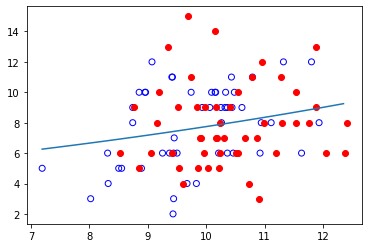

In [11]:
plt.scatter(control_x, control_y, label='C', facecolors='none', color='b')
plt.scatter(treatment_x, treatment_y, label='T', color='r')
plt.plot(xx, lambda_value)

### 3.5 説明変数が因子型の統計モデル

In [14]:
model2 = smf.glm(formula='y ~ f2', data=df, family=sm.families.Poisson())

# logλ(i) = β1 + β3 * f2
# 当てはまりの良さ(対数尤度): -237.63(xを利用した時よりも小さい値になっている)
# β1(Intercept: 切片)の最尤推定値: 2.0516
# β2(xの傾き)の最尤推定値: 0.0128(肥料がある方が少しだけ種子量にプラスということ)
print(model2.fit().summary())

                 Generalized Linear Model Regression Results                  
Dep. Variable:                      y   No. Observations:                  100
Model:                            GLM   Df Residuals:                       98
Model Family:                 Poisson   Df Model:                            1
Link Function:                    Log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -237.63
Date:                Fri, 13 Jan 2023   Deviance:                       89.475
Time:                        17:47:28   Pearson chi2:                     87.1
No. Iterations:                     4   Pseudo R-squ. (CS):          0.0003192
Covariance Type:            nonrobust                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      2.0516      0.051     40.463      0.0

### 3.6 説明変数が数量型 + 因子型の統計モデル

In [15]:
model3 = smf.glm(formula='y ~ x + f2', data=df, family=sm.families.Poisson())

# logλ(i) = β1 + β2 * x + β3 * f2
# 当てはまりの良さ(対数尤度): -235.63(一番大きい値となっている)
print(model3.fit().summary())

                 Generalized Linear Model Regression Results                  
Dep. Variable:                      y   No. Observations:                  100
Model:                            GLM   Df Residuals:                       97
Model Family:                 Poisson   Df Model:                            2
Link Function:                    Log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -235.29
Date:                Fri, 13 Jan 2023   Deviance:                       84.808
Time:                        18:29:04   Pearson chi2:                     83.8
No. Iterations:                     4   Pseudo R-squ. (CS):            0.04590
Covariance Type:            nonrobust                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      1.2631      0.370      3.417      0.0